# Using TensorFlow to run Monte Carlo Simulations

This notebook will show how I worked through creating a Monte Carlo Simulation using TensorFlow. The inspiration for this post comes from [Matthias Groncki](https://ipythonquant.wordpress.com/2018/05/22/tensorflow-meets-quantitative-finance-pricing-exotic-options-with-monte-carlo-simulations-in-tensorflow/). Matthias covered multiple options but I will only cover the plain vanilla call at first since that is what I use to trade (poorly I might add).

**Current Environment**  
Windows 10  
Python 3.6.1  
Anaconda3 4.4.0  
TensorFlow 1.2.0  
Keras 2.0.5  
NumPy 1.12.1  
MatPlotLib 2.0.2  

**Call Option**  
I am going to use a plain vanilla call. A call is when you buy a call with a certain strike price and a certain expiration date. Buying the call means that you promise to buy that stock at a set price on a set date. Typically, there is something called an option premium that you will pay in order to enter into the contract. For example, let say that Wells Fargo (WFC) is trading at \$50 on August 30th. You think it will go up at least 10% before the end of the year. So, you would buy the December 21st expiration with a strike price of \$55. For the rights to buy that you would pay \$3 in options premium. There are 3 common scenarios. First, the stock stays below $55 and you lose the premium and you don't get the shares. Second, the stock goes above \$55 and you get to purchase those shares for \$55. Third, you sell the options to someone else and collect the money.  

This value at maturity would be:  $$C = max(S_T - K, 0)$$  
Where $S_T$ is the price of the underlying stock on the maturity date  
$K$ is the strike price  

**Code for a call option**  
Current stock price: \$50  
Strike price: \$55  
Maturity Date: 3 months (I am going to round this since August 30th is my birthday and I wanted to use it)  
Risk Free Interest Rate: 2% (I didn't mention this earlier but this is used in most financial formulas to assess risk. You need to know what you could get risk free. Think a savings account or CD)  

In [1]:
#Notebook Imports
import tensorflow as tf
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

**Some Math**  
The Black-Scholes call formula is: $$C(S,t) = S_tN(d_1) - Ke^{-r(T-t)}N(d_2)$$  
Where $S_t$ is the stock price  
$N(*)$ is the cumulative distribution function of the standard normal distribution (Don't worry scipy does this part)  
$K$ is the strike price  
$r$ is the risk free rate (annual rate)  
$T - t$ is the time to maturity (in years)  
$\sigma$ is the volatility of the stock (aka standard deviation of the asset returns)

$$d_1 = \frac{ln(\frac{s}{K}) + (r + \frac{\sigma^2}{2}) (T-t)}{\sigma \sqrt{T-t}}$$  
$$d_2 = d_1 - \sigma \sqrt{T-t} = \frac{ln(\frac{s}{K}) + (r - \frac{\sigma^2}{2}) (T-t)}{\sigma \sqrt{T-t}}$$  

**Side Note**  
If these were dividend paying stocks the $d_1$ and $d_2$ would be slightly different and look like this:  
$$d_1 = \frac{ln(\frac{s}{K}) + (r - q + \frac{\sigma^2}{2}) (T-t)}{\sigma \sqrt{T-t}}$$  
$$d_2 = \frac{ln(\frac{s}{K}) + (r - q - \frac{\sigma^2}{2}) (T-t)}{\sigma \sqrt{T-t}}$$  
Where $q$ is the dividend rate

In [2]:
def blackscholes(stockPrice, strike, time_to_expr, imp_vol, risk_free):
    #S: Stock Price
    #K: Strike Price
    #T: Time to Maturity
    #Sigma: Volatility of underlying asset
    #r: Interest Rate
    
    S = stockPrice
    K = strike
    T = time_to_expr
    sigma = imp_vol
    r = risk_free
    
    d_1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d_2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return (S * stats.norm.cdf(d_1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d_2,0.0,1.0))

In [14]:
blackscholes(50.,55.,0.25,0.2,0.02)

0.52196991972285289

**Results**  
The today price that is returned is 0.52. That means that if the option is "perfectly" priced it would cost you \$0.52.

**TensorFlow Time!**  
Now, we will do the same thing using TensorFlow. Note that we will return the price as well as all the "greek" values.  

A thing to note, Matthias is using 1.8 of TensorFlow and can use 'tf.distributions.Normal' but I am using 1.2 so I have to use 'tf.contrib.distributions'. I could update but I would need to make sure that all of my other projects continue to work. Mainly, my OpenAI projects.

In [3]:
def blackscholes_tf(show_greeks = True):
    #Build the graphs
    S = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    T = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    
    d_1 = (tf.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * tf.sqrt(T))
    d_2 = (tf.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * tf.sqrt(T))
    npv = S * tf.contrib.distributions.Normal(0.,1.).cdf(d_1) - K * tf.exp(-r * T) * tf.contrib.distributions.Normal(0.,1.).cdf(d_2)
    target_calc = [npv]
    if show_greeks:
        greeks = tf.gradients(npv, [S, sigma, r, K, T])
        dS_2ndOrder = tf.gradients(greeks[0], [S, sigma, r, K, T])
        #Calculate mixed 2nd order
        dsigma_2ndOrder = tf.gradients(greeks[1], [S, sigma, r, K, T])
        dr_2ndOrder = tf.gradients(greeks[2], [S, sigma, r, K, T])
        dK_2ndOrder = tf.gradients(greeks[3], [S, sigma, r, K, T])
        dT_2ndOrder = tf.gradients(greeks[4], [S, sigma, r, K, T])
        target_calc += [greeks, dS_2ndOrder, dsigma_2ndOrder, dr_2ndOrder, dK_2ndOrder, dT_2ndOrder]
        
    def exec_graph(stockPrice, strike, time_to_expr, imp_vol, risk_free):
        with tf.Session() as sess:
            res = sess.run(target_calc,
                           {
                               S: stockPrice,
                               K: strike,
                               r: risk_free,
                               sigma: imp_vol,
                               T: time_to_expr
                           })
            return res
    return exec_graph

In [29]:
bs_tf = blackscholes_tf()
bs_tf(50.,55.,0.25,0.2,0.02)

[0.5219698,
 [0.19680142, 6.9312944, 2.329525, -0.16942, 2.9588795],
 [0.05545029, 1.3212436, 0.69312859, -0.050409377, 0.58394784],
 [1.3212451, 28.178972, 14.782742, -1.0751084, 26.316799],
 [0.69312906, 14.782745, 8.0817337, -0.58776236, 15.877737],
 [-0.050409406, -1.0751081, -0.58776236, 0.045826733, -0.47706416],
 [0.58394831, 26.316769, 15.877747, -0.47706437, -0.038589478]]

**Results**  
As you can see we again get \$0.52. Now, this took quite a bit longer to run and that will be an issue if we are wanting to run these at scale.

**Monte Carlo Time!!**  

In [12]:
def create_tf_graph_for_simulate_paths():
    S = tf.placeholder(tf.float32) #Stock Price
    K = tf.placeholder(tf.float32) #Strike Price
    dt = tf.placeholder(tf.float32) #Time Delta
    T = tf.placeholder(tf.float32) #Time to Maturity
    sigma = tf.placeholder(tf.float32) #Volatility of underlying asset
    r = tf.placeholder(tf.float32) #Interest Rate (risk free)
    dw  = tf.placeholder(tf.float32) #Normal distributed random variables
    S_T = S * tf.cumprod(tf.exp((r - 0.5 * sigma ** 2) * dt + sigma * tf.sqrt(dt) * dw), axis = 1)
    return (S, K, dt, T, sigma, r, dw, S_T)

In [13]:
def make_path_simulator():
    (S, K, dt, T, sigma, r, dw, S_T) = create_tf_graph_for_simulate_paths()
    def paths(S_0, strike, time_to_expiry, implied_vol, risk_free, seed, n_sims, obs):
        if seed != 0:
            np.random.seed(seed)
        stdnorm_random_variates = np.random.randn(n_sims, obs)
        with tf.Session() as sess:
            timedelta = time_to_expiry / stdnorm_random_variates.shape[1]
            res = sess.run(S_T,
                          {
                              S: S_0,
                              K: strike,
                              r: risk_free,
                              sigma: implied_vol,
                              dt: timedelta,
                              T: time_to_expiry,
                              dw: stdnorm_random_variates
                          })
            return res
    return paths

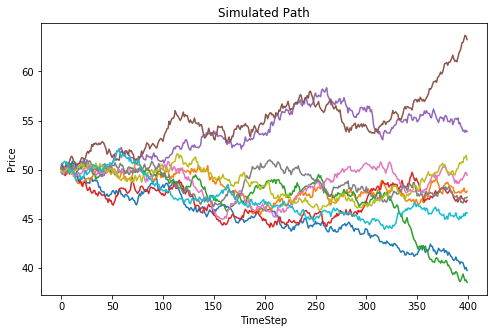

In [46]:
path_simulator = make_path_simulator()
paths = path_simulator(50.,55.,0.25,0.2,0.02, 187, 10, 400) #Seed 1312, #Sims 10, #Obs: 400
plt.figure(figsize=(8,5))
_ = plt.plot(np.transpose(paths))
_ = plt.title('Simulated Path')
_ = plt.ylabel('Price')
_ = plt.xlabel('TimeStep')
plt.show()

In [47]:
#Check if the expected value of the simulation is close to the expected mean
path_simulator = make_path_simulator()
paths = path_simulator(50.,55.,0.25,0.2,0.02,187, 10000000, 2)
assert np.mean(paths[:, 1])-np.exp(0.03*2)*100<0.01,'Value is too large'

**Pricing the option**  
Now, we are going to price the option by extending the previous function

In [41]:
def create_plain_vanilla_mc_tf_pricer(enable_greeks = True):
    (S,K, dt, T, sigma, r, dw, S_T) = create_tf_graph_for_simulate_paths()
    payout = tf.maximum(S_T[:,-1] - K, 0)
    npv = tf.exp(-r*T) * tf.reduce_mean(payout)
    target_calc = [npv]
    if enable_greeks:
        greeks = tf.gradients(npv, [S, sigma, r, K, T])
        target_calc += [greeks]
    def pricer(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, seed, n_sims):
        if seed != 0:
            np.random.seed(seed)
        stdnorm_random_variates = np.random.randn(n_sims, 1)
        with tf.Session() as sess:
            timedelta = time_to_expiry / stdnorm_random_variates.shape[1]
            res = sess.run(target_calc, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt : timedelta,
                               T: time_to_expiry,
                               dw : stdnorm_random_variates
                         })
            return res
    return pricer

In [48]:
plain_vanilla_mc_tf_pricer = create_plain_vanilla_mc_tf_pricer()
plain_vanilla_mc_tf_pricer(50.,55.,0.25,0.2,0.02, 187, 1000000)

[0.52246714, [0.19729821, 6.9443903, 2.3356104, -0.16987336, -0.010449342]]

**Conclusion**  
We have verified that our TensorFlow implementation gets the same solution as the straight python implementation. Many thanks to Matthias for inspiring me to dig into TensorFlow using Monte Carlo Simulations